In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import shuffle
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle
import kipoiseq
from itertools import combinations
import scipy
import os
import gene as bgene
import shuffle
from scipy.stats import pearsonr
import tensorflow_hub as hub

import copy
from pymemesuite.fimo import FIMO
from pymemesuite.common import MotifFile
import Bio.SeqIO
from pymemesuite.common import Sequence

2024-01-23 05:00:38.177157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')
cell_lines_for_search = ['K562 ENCODE, biol_']
track_index = [i for i, t in enumerate(target_df['description']) if
       ('CAGE' in t) and (t.split(':')[-1].strip() in cell_lines_for_search)]
cell_line_info = {}
for target_cell_line in cell_lines_for_search:
    cell_line_info[target_cell_line] = {}
    targets = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() == target_cell_line)]

    cell_line_info[target_cell_line]['output'] = [np.argwhere(np.array(track_index) == t).flatten()[0] for t in
                                                  targets]
    cell_line_info[target_cell_line]['target'] = '&'.join([str(t) for t in targets])

In [99]:
cage_tracks = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() in ['K562 ENCODE, biol_',
                                                               'GM12878 ENCODE, biol_',
                                                               'PC-3'])]


[8172, 8173, 8174, 8175, 8176, 8177, 8178, 8179]

In [108]:
model = custom_model.Borzoi('../data/borzoi/*/*', track_index=cage_tracks, aggregate=False)
model.bin_index = list(np.arange(model.target_lengths // 2 - 4, model.target_lengths // 2 + 4, 1))



Adding models:
['../data/borzoi/f0/model0_best.h5', '../data/borzoi/f1/model0_best.h5', '../data/borzoi/f2/model0_best.h5', '../data/borzoi/f3/model0_best.h5']


In [75]:
model_name = 'borzoi'
result_dir = '../results/'
csv_dir = f'{result_dir}/summary_csvs/{model_name}' # dir with all summary csvs

selected_gene_csvs = glob.glob(f'{csv_dir}/*selected_genes.csv')
tss_df = pd.concat(pd.read_csv(f, index_col='Unnamed: 0') for f in selected_gene_csvs) # load selected gene lists


In [76]:
row = tss_df.iloc[0]
row

Chromosome                           chr12
Start                            124989131
gene_name                            DHX37
gene_id                  ENSG00000150990.9
Strand                                   -
K562 ENCODE, biol_                 5.78125
GM12878 ENCODE, biol_                  NaN
PC-3                                   NaN
Name: 33921, dtype: object

In [92]:
pred_wt[0][:, bin_index].mean(axis=1).mean(axis=1).mean()

8.97

In [77]:
seq_parser = utils.SequenceParser('../data/GRCh38.primary_assembly.genome.fa')

In [78]:
seq_halflen = model.seq_length // 2
N_shuffles = 1
half_window_size = 2500

In [79]:
x = seq_parser.extract_seq_centered(row['Chromosome'], row['Start'], row['Strand'], model.seq_length)


In [80]:
pred_wt, pred_mut = creme.context_dependence_test(model, x,
                                                            [seq_halflen - half_window_size, seq_halflen + half_window_size],
                                                            N_shuffles, mean=False)

In [95]:
cage_bins = np.arange(model.target_lengths // 2-4, model.target_lengths // 2+4, 1)
cage_bins

array([8172, 8173, 8174, 8175, 8176, 8177, 8178, 8179])

In [109]:
pred = model.predict(x)

In [111]:
pred.shape

(1, 4, 8, 6)

In [28]:
bin_index = list(np.arange(model.target_lengths // 2 - 4, model.target_lengths // 2 + 4, 1))


In [29]:
bin_index

[8172, 8173, 8174, 8175, 8176, 8177, 8178, 8179]

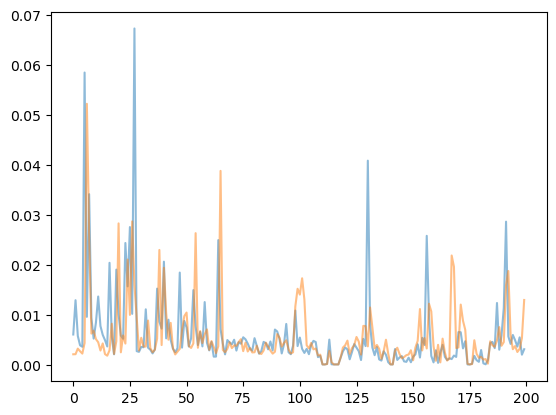

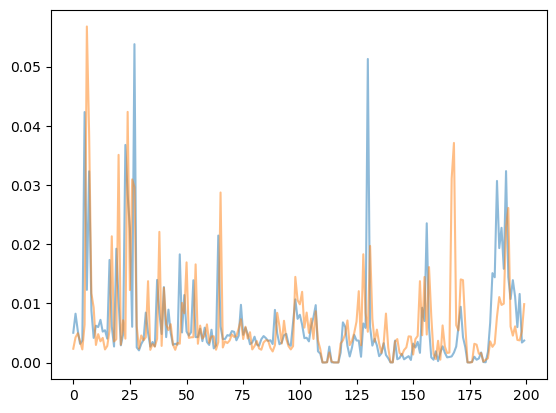

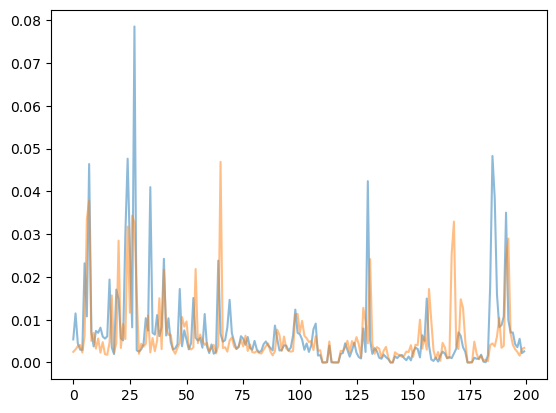

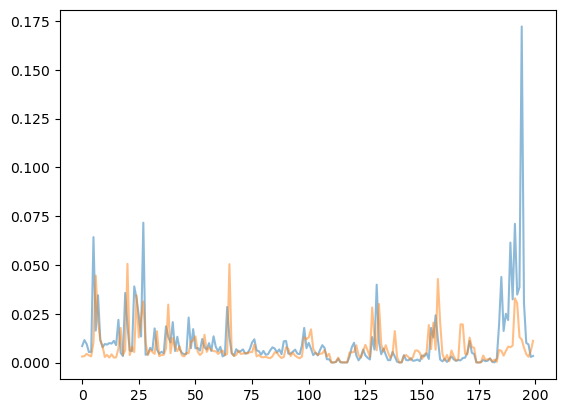

In [67]:
for p in pred_mut[0]:
    plt.plot(p[8000:8200,0], alpha=0.5)
    plt.plot(p[8000:8200,1], alpha=0.5)
    # for b in bin_index:
    #     plt.vlines(b)
    plt.show()

[872, 873]

In [112]:
res = utils.read_pickle('../results/gencode_tss_predictions/borzoi/A2ML1_chr12_8822620_+.pickle')

In [114]:
res.shape

(1, 4, 8, 6)